## Import

In [1]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

## Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [3]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [4]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [5]:
df_village = pd.read_csv('../../../data/processed/cleaned_village-hotel-changi-by-far-east-hospitality.csv')
df_park = pd.read_csv('../../../data/processed/cleaned_park-regis.csv')
df_grand = pd.read_csv('../../../data/processed/cleaned_grand-mercure-sg-roxy.csv')
df_paradox = pd.read_csv('../../../data/processed/cleaned_paradox-sg-merchant-court.csv')
df_crown = pd.read_csv('../../../data/processed/cleaned_crowne-plaza.csv')


df_combi = pd.concat([df_village, df_park, df_grand, df_paradox, df_crown])

To ensure our files do not include irrelevant words, we have extended the stopwords from nltk to include relevant stopwords from the files below.

In [6]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['date'] >= '2015-01-01']

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.extend(['regis', 'park_regis', 'changi', 'far_east', 'east_hospitality', 'village', 'grand_mercure', 'mercure', 'roxy',
          'paradox', 'merchant', 'merchant_court', 'crowne', 'crowne_plaza', 'crown', 'plaza', 'clark', 'quay', 'marina'])
stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


To analyse whether using a stemmed version of the reviews or a lemmatized version of the reviews would produce better LDA results, we will be conducting analysis on both. The reviews will be determined by the coherence score of both stemmed and lemmatized reviews.

## Stemmed

In [37]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['stem_tokens'] = df_filtered['stem_review'].apply(preprocess)

In [8]:
##Generate LDA dictionary and corpus
#stem_dict = corpora.Dictionary(df_filtered['stem_tokens']) #use if we want to rerun
#stem_dict.save('4star_stem')
stem_dict = corpora.Dictionary.load('4star_stem')
stem_corpus = [stem_dict.doc2bow(text) for text in df_filtered['stem_tokens']]

In [9]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    stem_ldamodel = lda(stem_corpus, num_topics=i, id2word=stem_dict, passes=15, random_state=0)
    
    stem_coherence = CoherenceModel(model=stem_ldamodel, texts=df_filtered['stem_tokens'], dictionary=stem_dict, coherence='c_v')
    lda_coherence = stem_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.44017513425934707
The coherence score at topic 3 is 0.43315025185484113
The coherence score at topic 4 is 0.44327229084214576
The coherence score at topic 5 is 0.47657785742722736
The coherence score at topic 6 is 0.4665042077788812


In [10]:
## Use 5 topics as determined by coherence
lda = gensim.models.ldamodel.LdaModel
stem_ldamodel = lda(stem_corpus, num_topics=5, id2word=stem_dict, passes=15, random_state=0)

In [11]:
# For all stemmed data
topics_stem = stem_ldamodel.show_topics(formatted=False, num_words=20)
data_flat_stem = [word for word_list in df_filtered['stem_tokens'] for word in word_list]

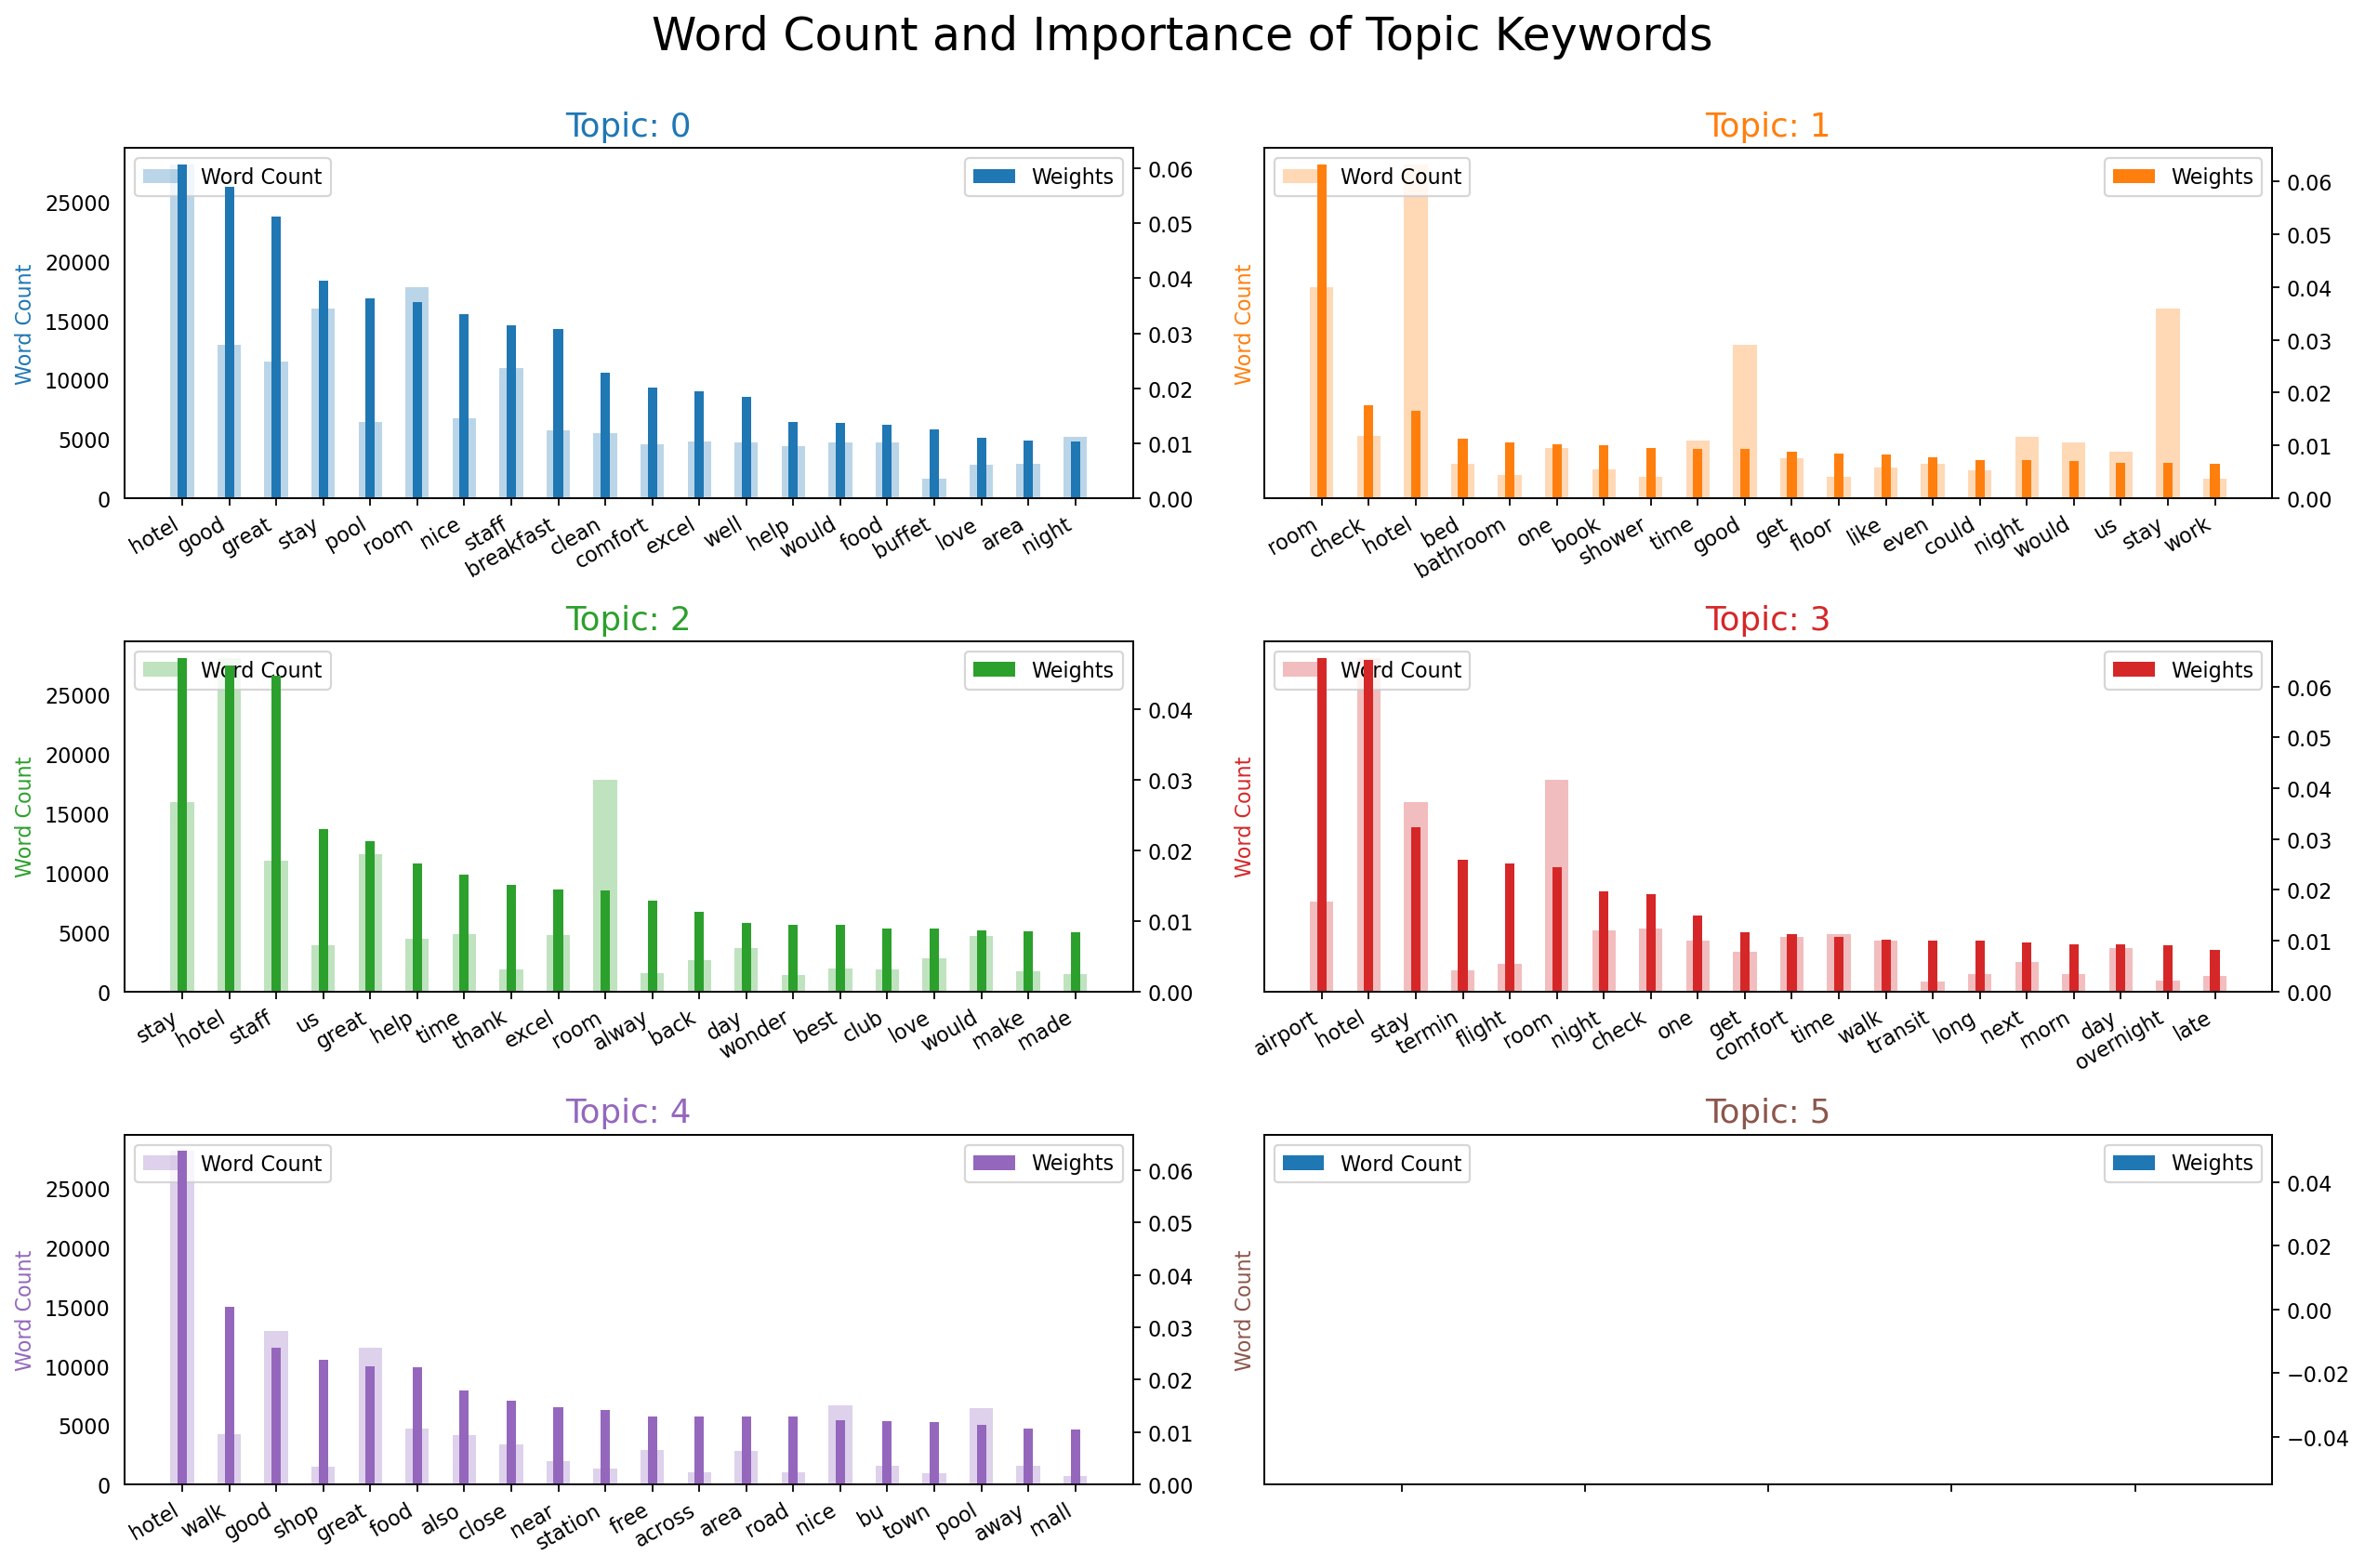

In [12]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For all topics
plot_word_count_importance(topics_stem, data_flat_stem, 'Word Count and Importance of Topic Keywords')

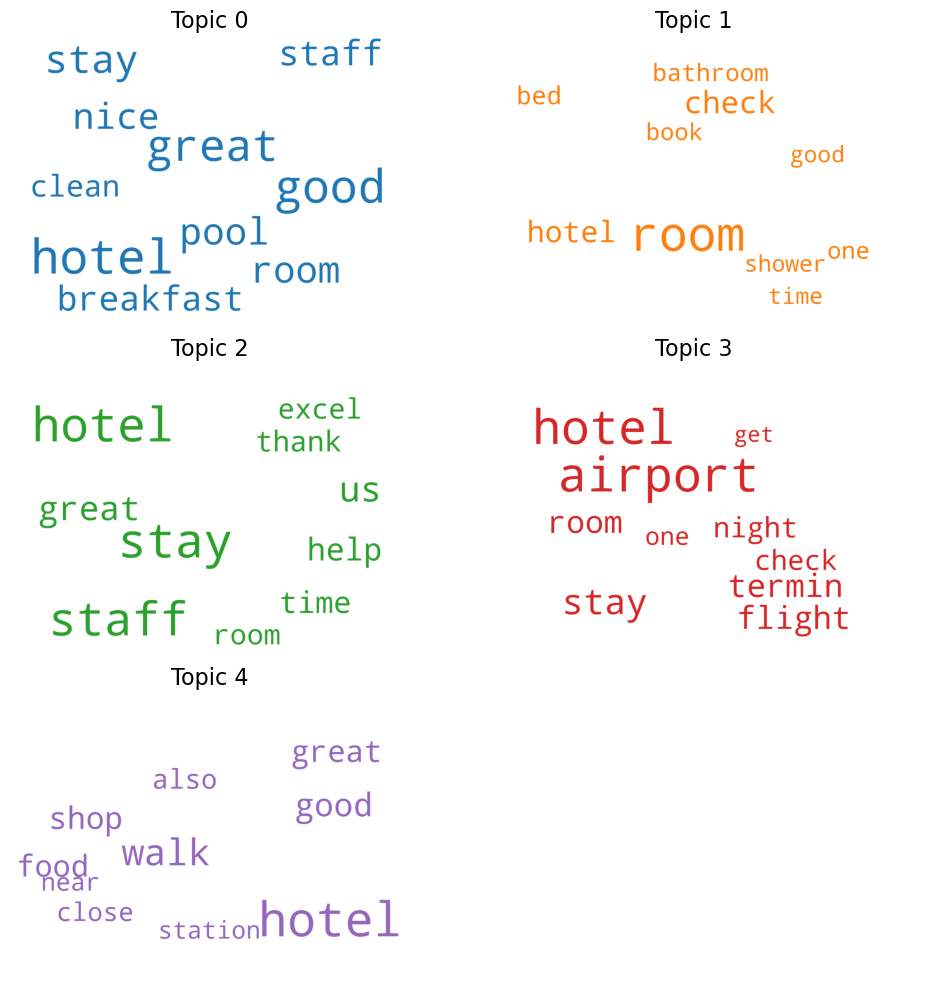

In [13]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(stem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for all topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [14]:
vis = pyLDAvis.gensim.prepare(topic_model=stem_ldamodel, corpus=stem_corpus, dictionary=stem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [76]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['lem_tokens'] = df_filtered['lem_review'].apply(preprocess)

In [77]:
## Generate LDA dictionary and corpus
#lem_dict = corpora.Dictionary(df_filtered['lem_tokens']) #used if you want to refresh dict
#lem_dict.save('4star_lem')
lem_dict = corpora.Dictionary.load('4star_lem')
lem_corpus = [lem_dict.doc2bow(text) for text in df_filtered['lem_tokens']]

In [78]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    lem_ldamodel = lda(lem_corpus, num_topics=i, id2word=lem_dict, passes=15, random_state=0)
    
    lem_coherence = CoherenceModel(model=lem_ldamodel, texts=df_filtered['lem_tokens'], dictionary=lem_dict, coherence='c_v')
    lda_coherence = lem_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.39979529434499095
The coherence score at topic 3 is 0.3879080981512913
The coherence score at topic 4 is 0.4247026727989817
The coherence score at topic 5 is 0.4213477293022468
The coherence score at topic 6 is 0.42643002412547437


In [79]:
## Use 6 topics as determined by coherence
lda = gensim.models.ldamodel.LdaModel
lem_ldamodel = lda(lem_corpus, num_topics=6, id2word=lem_dict, passes=15, random_state=0)

In [80]:
# For All
topics_lem = lem_ldamodel.show_topics(formatted=False)
data_flat_lem = [word for word_list in df_filtered['lem_tokens'] for word in word_list]

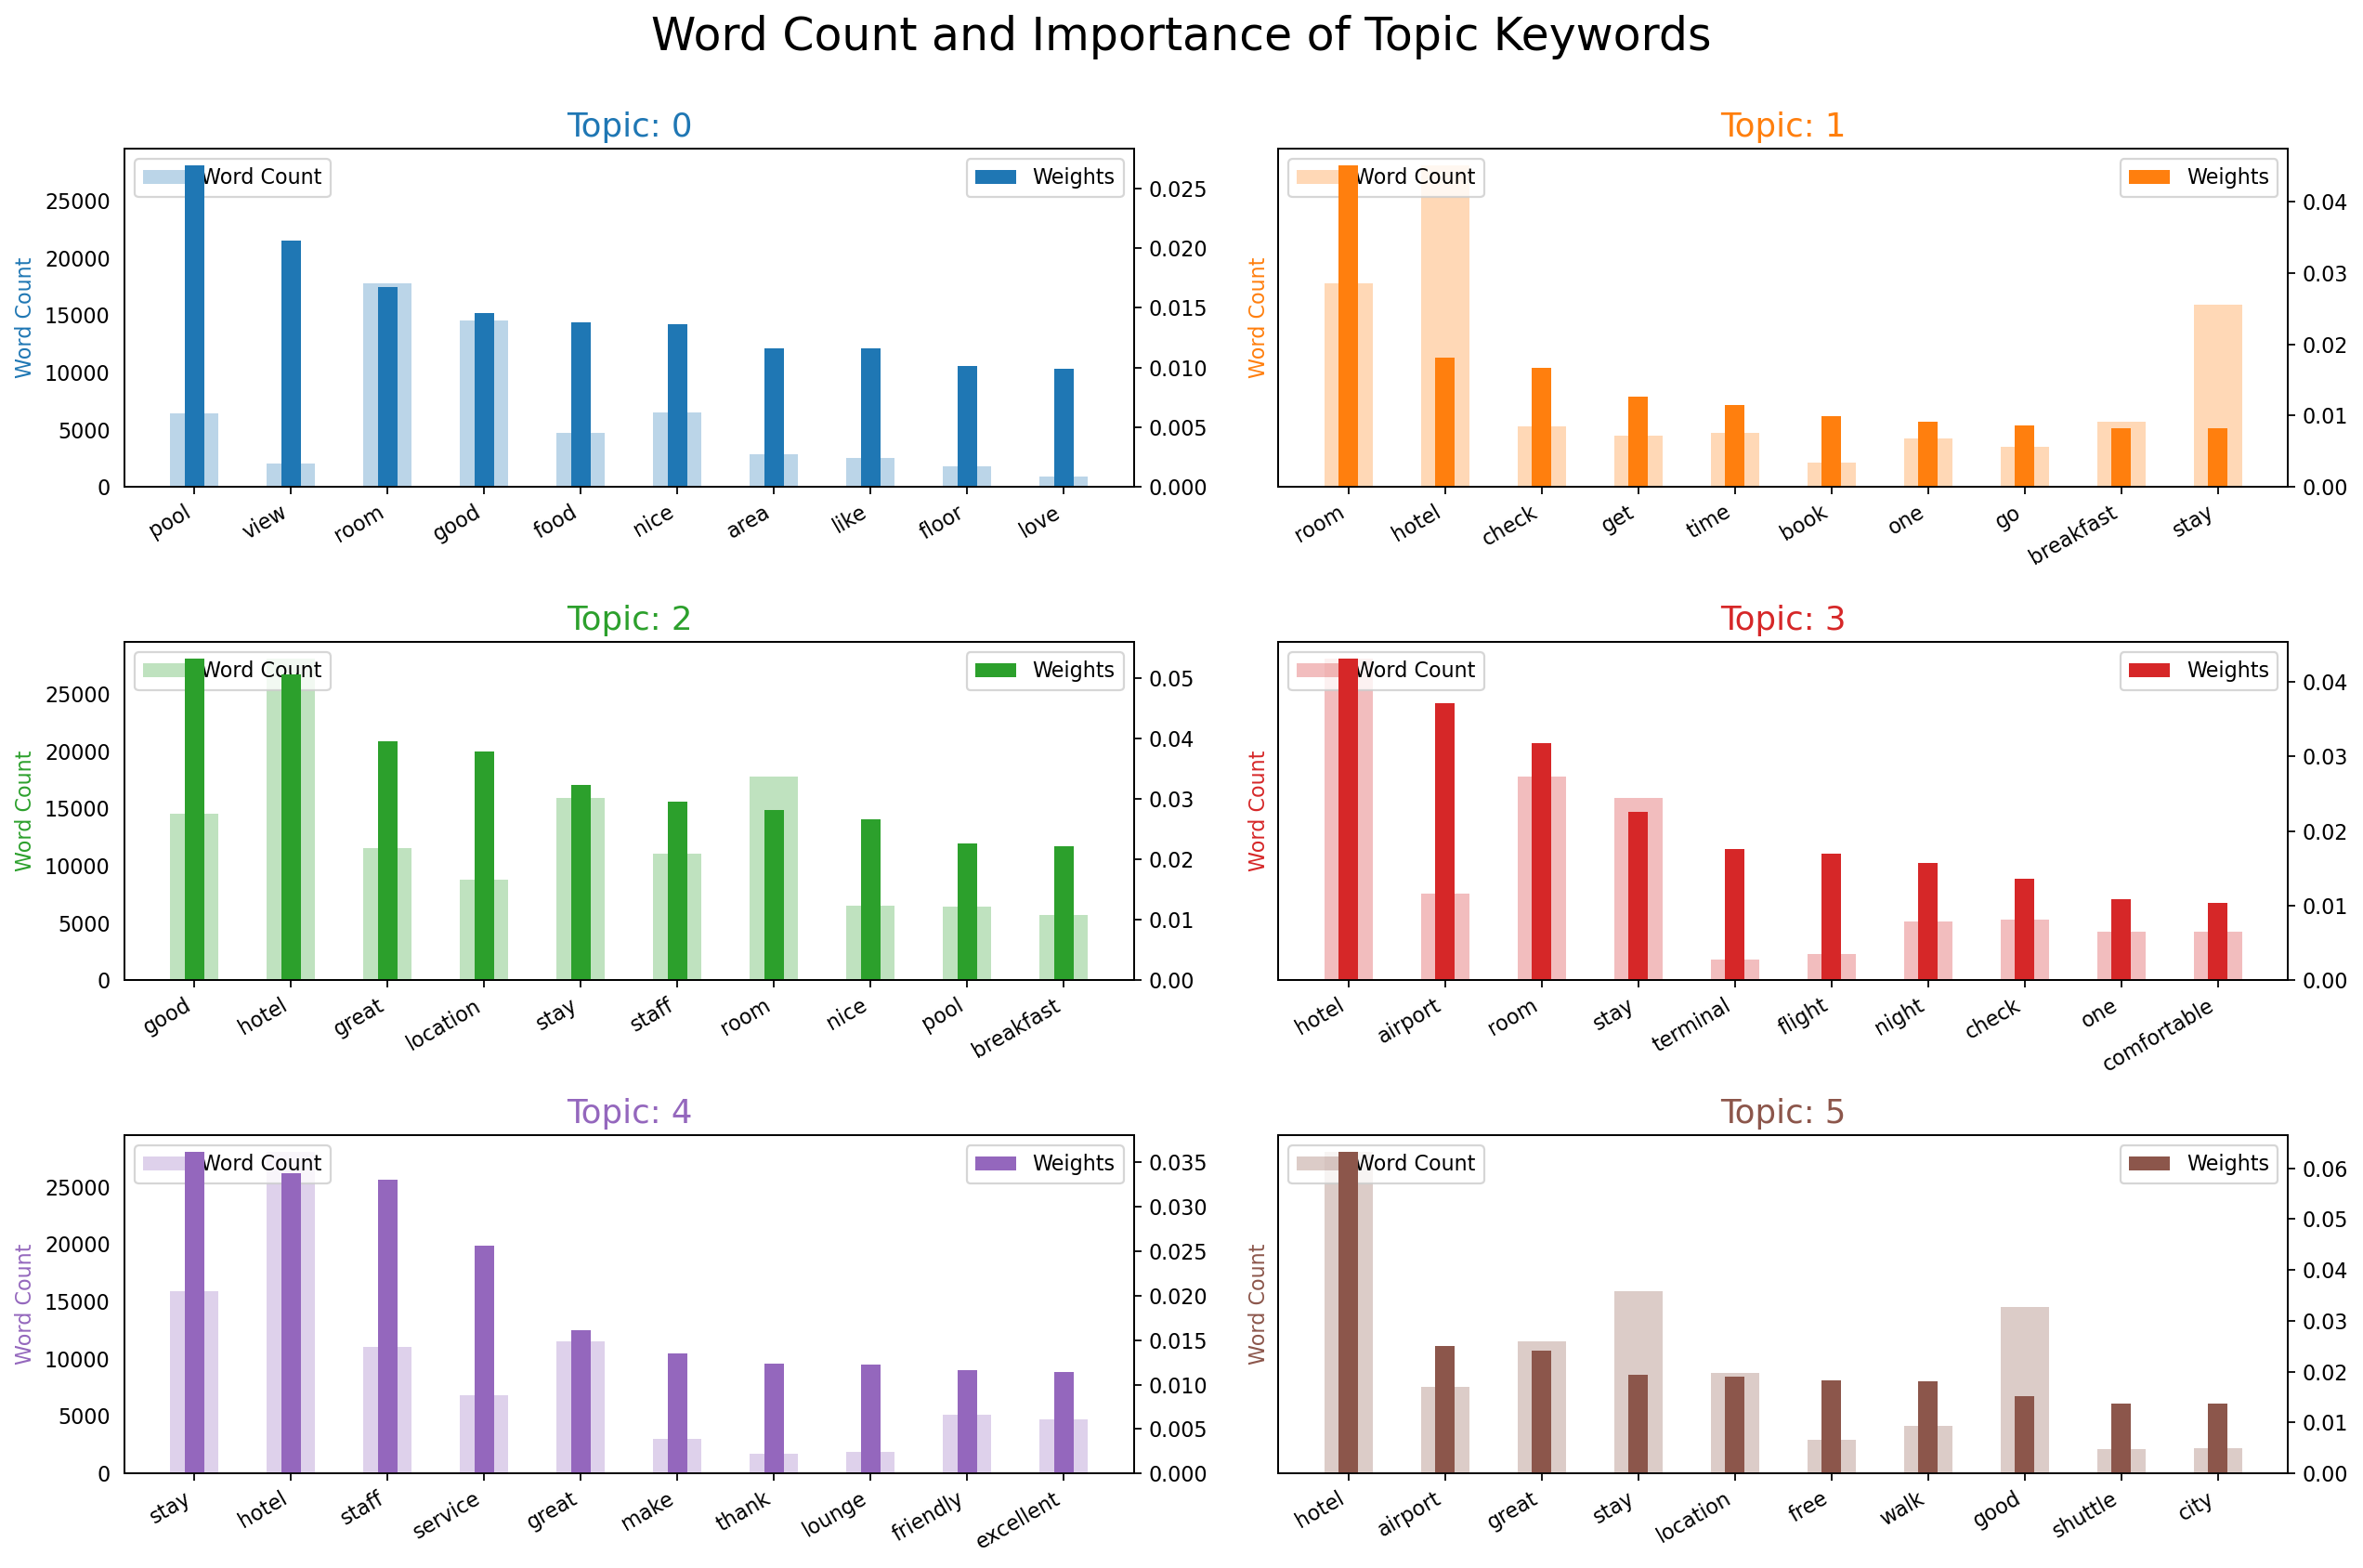

In [81]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For all topics
plot_word_count_importance(topics_lem, data_flat_lem, 'Word Count and Importance of Topic Keywords')

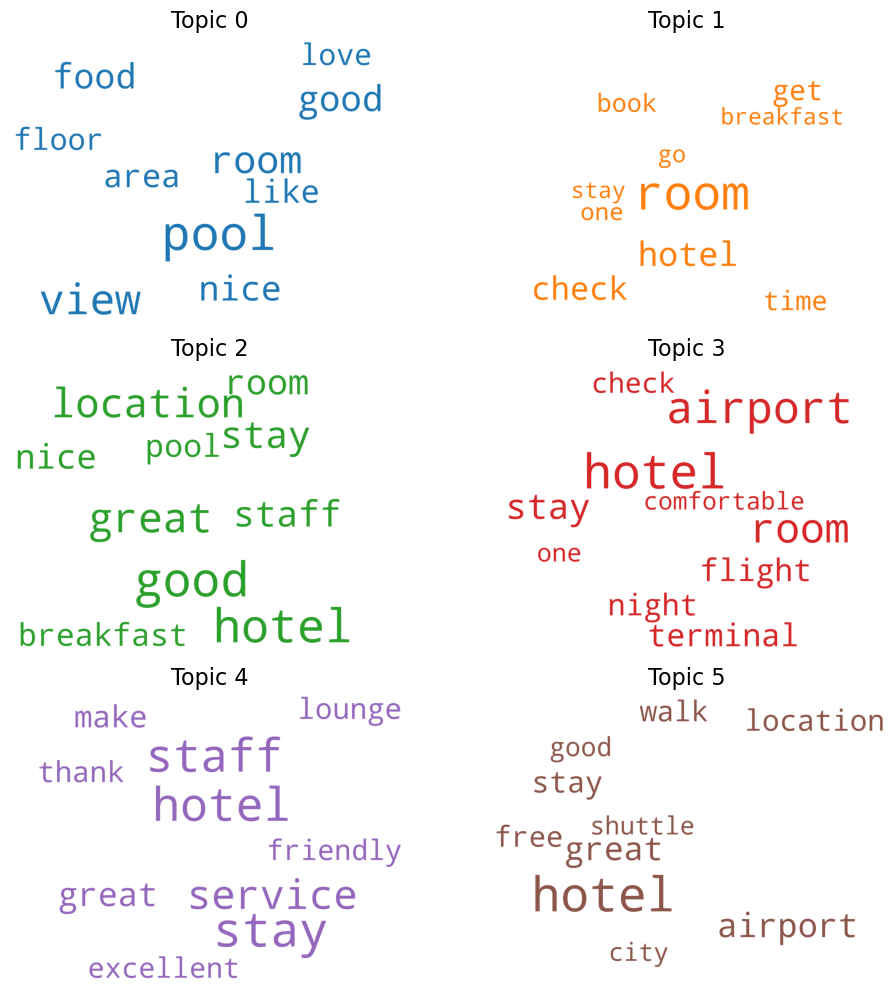

In [82]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(lem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for all topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [83]:
vis = pyLDAvis.gensim.prepare(topic_model=lem_ldamodel, corpus=lem_corpus, dictionary=lem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

We find that stem reviews produce a much higher coherence than lemmatized reviews, and thus will use stemmed reviews to conduct our analysis.

## Aspect Extraction

In [17]:
topics_stem

[(0,
  [('hotel', 0.06066543),
   ('good', 0.05662687),
   ('great', 0.051247127),
   ('stay', 0.039658293),
   ('pool', 0.036424354),
   ('room', 0.035750892),
   ('nice', 0.03357231),
   ('staff', 0.031510737),
   ('breakfast', 0.030704545),
   ('clean', 0.022773447),
   ('comfort', 0.020109307),
   ('excel', 0.019477336),
   ('well', 0.018372677),
   ('help', 0.013885156),
   ('would', 0.013775486),
   ('food', 0.01340219),
   ('buffet', 0.012523241),
   ('love', 0.010999166),
   ('area', 0.010570749),
   ('night', 0.010390278)]),
 (1,
  [('room', 0.06312547),
   ('check', 0.017642308),
   ('hotel', 0.01647614),
   ('bed', 0.011348137),
   ('bathroom', 0.010589932),
   ('one', 0.010202156),
   ('book', 0.010044039),
   ('shower', 0.009454524),
   ('time', 0.009368337),
   ('good', 0.00930641),
   ('get', 0.00887617),
   ('floor', 0.008515672),
   ('like', 0.00827102),
   ('even', 0.0077712038),
   ('could', 0.0072875964),
   ('night', 0.0071407855),
   ('would', 0.007056457),
   ('u

In [18]:
top_dict = {}
for i in topics_stem:
    top_dict[i[0]] = []
    for j in i[1]:
        print(j)
        top_dict[i[0]].append(j[0])

('hotel', 0.06066543)
('good', 0.05662687)
('great', 0.051247127)
('stay', 0.039658293)
('pool', 0.036424354)
('room', 0.035750892)
('nice', 0.03357231)
('staff', 0.031510737)
('breakfast', 0.030704545)
('clean', 0.022773447)
('comfort', 0.020109307)
('excel', 0.019477336)
('well', 0.018372677)
('help', 0.013885156)
('would', 0.013775486)
('food', 0.01340219)
('buffet', 0.012523241)
('love', 0.010999166)
('area', 0.010570749)
('night', 0.010390278)
('room', 0.06312547)
('check', 0.017642308)
('hotel', 0.01647614)
('bed', 0.011348137)
('bathroom', 0.010589932)
('one', 0.010202156)
('book', 0.010044039)
('shower', 0.009454524)
('time', 0.009368337)
('good', 0.00930641)
('get', 0.00887617)
('floor', 0.008515672)
('like', 0.00827102)
('even', 0.0077712038)
('could', 0.0072875964)
('night', 0.0071407855)
('would', 0.007056457)
('us', 0.006762563)
('stay', 0.006739076)
('work', 0.006467629)
('stay', 0.04730338)
('hotel', 0.046276893)
('staff', 0.0447593)
('us', 0.023029383)
('great', 0.02126

In [19]:
top_dict

{0: ['hotel',
  'good',
  'great',
  'stay',
  'pool',
  'room',
  'nice',
  'staff',
  'breakfast',
  'clean',
  'comfort',
  'excel',
  'well',
  'help',
  'would',
  'food',
  'buffet',
  'love',
  'area',
  'night'],
 1: ['room',
  'check',
  'hotel',
  'bed',
  'bathroom',
  'one',
  'book',
  'shower',
  'time',
  'good',
  'get',
  'floor',
  'like',
  'even',
  'could',
  'night',
  'would',
  'us',
  'stay',
  'work'],
 2: ['stay',
  'hotel',
  'staff',
  'us',
  'great',
  'help',
  'time',
  'thank',
  'excel',
  'room',
  'alway',
  'back',
  'day',
  'wonder',
  'best',
  'club',
  'love',
  'would',
  'make',
  'made'],
 3: ['airport',
  'hotel',
  'stay',
  'termin',
  'flight',
  'room',
  'night',
  'check',
  'one',
  'get',
  'comfort',
  'time',
  'walk',
  'transit',
  'long',
  'next',
  'morn',
  'day',
  'overnight',
  'late'],
 4: ['hotel',
  'walk',
  'good',
  'shop',
  'great',
  'food',
  'also',
  'close',
  'near',
  'station',
  'free',
  'across',
  'ar

In [20]:
df_res = pd.DataFrame(top_dict)
df_res

,0,1,2,3,4
0,hotel,room,stay,airport,hotel
1,good,check,hotel,hotel,walk
2,great,hotel,staff,stay,good
3,stay,bed,us,termin,shop
4,pool,bathroom,great,flight,great
5,room,one,help,room,food
6,nice,book,time,night,also
7,staff,shower,thank,check,close
8,breakfast,time,excel,one,near
9,clean,good,room,get,station


In [21]:
df_res.to_csv('../../../data/lda/4-star LDA.csv')

## Import PyABSA

pyABSA acts as the ground truth in our analysis, and thus we will be tagging the pyABSA reviews to the topics identified above.

In [22]:
df_test = pd.read_json('../pyABSA_outputs/Aspect_Term_Extraction_and_Polarity_Classification_FAST_LCF_ATEPC.json')

In [23]:
df_test

,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence
0,clean comfort hotel room find decent hotel tra...,"[O, B-ASP, O, O, O, O, O, O, O, B-ASP, O, O, O...","[clean, comfort, hotel, room, find, decent, ho...","[comfort, food, glass, closet space, port]","[[1], [9], [30], [37, 38], [47]]","[Positive, Negative, Negative, Negative, Negat...","[[0.022732432931661002, 0.002103362465277, 0.9...","[0.9752000000000001, 0.922, 0.8991, 0.86620000..."
1,good hotel great great place great room small ...,"[O, O, O, O, B-ASP, O, O, O, O, O, O, O, O, O,...","[good, hotel, great, great, place, great, room...",[place],[[4]],[Positive],"[[0.0005702517228200001, 0.0003066391509490000...",[0.9991000000000001]
2,good place decent price good place good price ...,"[O, O, O, B-ASP, O, O, O, O, O, O, O, O, B-ASP...","[good, place, decent, price, good, place, good...","[price, food]","[[3], [12]]","[Positive, Negative]","[[0.005487654823809001, 0.013030127622187, 0.9...","[0.9815, 0.912]"
3,great great staff neat hotel line star rate st...,"[O, O, B-ASP, O, O, O, O, O, O, B-ASP, I-ASP, ...","[great, great, staff, neat, hotel, line, star,...","[staff, front desk]","[[2], [9, 10]]","[Positive, Positive]","[[0.032106801867485005, 0.00041079759830600003...","[0.9675, 0.9994000000000001]"
4,good budget stay stay day nice seven eleven ne...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[good, budget, stay, stay, day, nice, seven, e...",[wait],[[18]],[Positive],"[[0.408927053213119, 0.019343916326761003, 0.5...",[0.5717]
...,...,...,...,...,...,...,...,...
68287,swiss hotel swiss stay hotel mani time recent ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[swiss, hotel, swiss, stay, hotel, mani, time,...","[size, staff, porter, crew]","[[15], [35], [67], [78]]","[Negative, Negative, Negative, Negative]","[[0.998076200485229, 0.001359648769721, 0.0005...","[0.9981000000000001, 0.9958, 0.9956, 0.9973000..."
68288,stay stay night wife ideal view th floor floor...,"[O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, O,...","[stay, stay, night, wife, ideal, view, th, flo...","[view, staff, air]","[[5], [25], [45]]","[Positive, Positive, Positive]","[[0.09106669574975901, 0.0005153458332640001, ...","[0.9084000000000001, 0.8150000000000001, 0.9484]"
68289,great view great decent room one night hotel v...,"[O, B-ASP, O, O, B-ASP, O, O, O, O, O, O, O, O...","[great, view, great, decent, room, one, night,...","[view, room, bathroom]","[[1], [4], [23]]","[Positive, Positive, Positive]","[[0.000963231665082, 0.000514330400619, 0.9985...","[0.9985, 0.9973000000000001, 0.9973000000000001]"
68290,hotel date old four night mani cup machin shop...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ASP,...","[hotel, date, old, four, night, mani, cup, mac...","[bed, cover]","[[13], [18]]","[Positive, Positive]","[[0.07999674975872001, 0.000742122647352, 0.91...","[0.9193, 0.6769000000000001]"


In [51]:
##Use 3 star review to find the end of 3 star and start of 4 star reviews

df_ibis = pd.read_csv('../../../data/processed/cleaned_ibis-sg-bencoolen.csv')
df_boss = pd.read_csv('../../../data/processed/cleaned_hotel-boss.csv')
df_g = pd.read_csv('../../../data/processed/cleaned_hotel-G.csv')
df_village = pd.read_csv('../../../data/processed/cleaned_village-hotel-albert-court-by-far-east-hospitality.csv')
df_holiday = pd.read_csv('../../../data/processed/cleaned_holiday-inn-express-clarke-quay.csv')


df_3star = pd.concat([df_ibis, df_boss, df_g, df_village, df_holiday]) ##combines the files together
df_3star = df_3star[df_3star['date'] >= '2015-01-01']

In [58]:
df_json = df_test.iloc[len(df_3star):len(df_3star) + len(df_filtered), :]

In [60]:
len(df_json) == len(df_filtered)##check if the number of elements is the same

True

In [61]:
df_json

,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence
14070,afford hotel afford pool bathtub mani bar arou...,"[O, O, O, O, O, O, B-ASP, O, O, O, O, B-ASP, O...","[afford, hotel, afford, pool, bathtub, mani, b...","[bar, staff]","[[6], [11]]","[Neutral, Positive]","[[0.000186667559319, 0.9976551532745361, 0.002...","[0.9977, 0.9989]"
14071,good near airport quiet surround walk local fo...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[good, near, airport, quiet, surround, walk, l...",[comfort room],"[[22, 23]]",[Positive],"[[0.00021306525741200002, 0.000266788410954, 0...",[0.9995]
14072,concern stay hotel follow posit room need righ...,"[O, O, O, O, O, O, O, O, O, O, O, B-ASP, O, O,...","[concern, stay, hotel, follow, posit, room, ne...","[mirror, seat area, view sea room, comfort]","[[11], [14, 15], [21, 22, 23], [25]]","[Negative, Negative, Positive, Positive]","[[0.8882124423980711, 0.11114367842674201, 0.0...","[0.8882, 0.5642, 0.8084, 0.9483]"
14073,love room level staff excel room clean wonder ...,"[O, O, O, B-ASP, O, O, O, O, O, O, O, O, O, O,...","[love, room, level, staff, excel, room, clean,...","[staff, sea view]","[[3], [16, 17]]","[Neutral, Positive]","[[0.011914117261767, 0.5904523134231561, 0.397...","[0.5905, 0.9995]"
14074,hotel told room book twin room accept unclean ...,"[O, O, O, O, O, O, O, O, O, O, B-ASP, O, O, O,...","[hotel, told, room, book, twin, room, accept, ...","[sound, price]","[[10], [16]]","[Negative, Negative]","[[0.998404204845428, 0.001349285361357, 0.0002...","[0.9984000000000001, 0.9978]"
...,...,...,...,...,...,...,...,...
32665,excel airport hotel hotel airport hotel access...,"[B-ASP, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[excel, airport, hotel, hotel, airport, hotel,...","[excel, bathroom shower room, gym, staff]","[[0], [21, 22, 23], [27], [31]]","[Neutral, Positive, Positive, Positive]","[[0.006580383516848001, 0.541573166847229, 0.4...","[0.5416000000000001, 0.9936, 0.9965, 0.9912000..."
32666,great view run way clean new room nice pool ar...,"[O, B-ASP, O, O, O, B-ASP, I-ASP, O, B-ASP, I-...","[great, view, run, way, clean, new, room, nice...","[view, new room, pool area, staff]","[[1], [5, 6], [8, 9], [22]]","[Positive, Positive, Positive, Neutral]","[[0.001381430891342, 0.0005314895533950001, 0....","[0.9981000000000001, 0.9993000000000001, 0.999..."
32667,us review cool airport hotel new super clean n...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[us, review, cool, airport, hotel, new, super,...","[common area, staff]","[[18, 19], [42]]","[Positive, Positive]","[[0.013092741370201002, 0.00023036444326800002...","[0.9867, 0.9994000000000001]"
32668,airport stay one night whilst return back impr...,"[O, O, O, O, O, O, O, O, O, B-ASP, O, O, O, O,...","[airport, stay, one, night, whilst, return, ba...","[staff, club]","[[9], [39]]","[Positive, Neutral]","[[0.002654893090948, 0.000245931529207, 0.9970...","[0.9971000000000001, 0.9975]"


In [63]:
df_json = df_json[['sentence', 'tokens', 'aspect', 'sentiment', 'confidence']]

In [64]:
df_json

,sentence,tokens,aspect,sentiment,confidence
14070,afford hotel afford pool bathtub mani bar arou...,"[afford, hotel, afford, pool, bathtub, mani, b...","[bar, staff]","[Neutral, Positive]","[0.9977, 0.9989]"
14071,good near airport quiet surround walk local fo...,"[good, near, airport, quiet, surround, walk, l...",[comfort room],[Positive],[0.9995]
14072,concern stay hotel follow posit room need righ...,"[concern, stay, hotel, follow, posit, room, ne...","[mirror, seat area, view sea room, comfort]","[Negative, Negative, Positive, Positive]","[0.8882, 0.5642, 0.8084, 0.9483]"
14073,love room level staff excel room clean wonder ...,"[love, room, level, staff, excel, room, clean,...","[staff, sea view]","[Neutral, Positive]","[0.5905, 0.9995]"
14074,hotel told room book twin room accept unclean ...,"[hotel, told, room, book, twin, room, accept, ...","[sound, price]","[Negative, Negative]","[0.9984000000000001, 0.9978]"
...,...,...,...,...,...
32665,excel airport hotel hotel airport hotel access...,"[excel, airport, hotel, hotel, airport, hotel,...","[excel, bathroom shower room, gym, staff]","[Neutral, Positive, Positive, Positive]","[0.5416000000000001, 0.9936, 0.9965, 0.9912000..."
32666,great view run way clean new room nice pool ar...,"[great, view, run, way, clean, new, room, nice...","[view, new room, pool area, staff]","[Positive, Positive, Positive, Neutral]","[0.9981000000000001, 0.9993000000000001, 0.999..."
32667,us review cool airport hotel new super clean n...,"[us, review, cool, airport, hotel, new, super,...","[common area, staff]","[Positive, Positive]","[0.9867, 0.9994000000000001]"
32668,airport stay one night whilst return back impr...,"[airport, stay, one, night, whilst, return, ba...","[staff, club]","[Positive, Neutral]","[0.9971000000000001, 0.9975]"


## Get PyABSA topics

In [65]:
def get_topics(lst, dictionary, sentiment, confidence, topics_list, vectorizer, transformer, model):
    ans = []
    for word in range(len(lst)):
        docbow = dictionary.doc2bow([lst[word]])
        if len(docbow) == 0:
            tpc = get_cosine_similarity(lst[word], topics_list, vectorizer, transformer)
            res = (tpc, sentiment[word], confidence[word])
        else:
            tpc = model.get_document_topics(docbow)
            new_tpc = []
            max_val = 0
            max_tpc = -1
            for c, v in tpc:
                if v > max_val:
                    max_val = v
                    max_tpc = c
            res = (max_tpc, sentiment[word], confidence[word])
        ans.append(res)
    return ans

In [66]:
def get_cosine_similarity(word, topics_list, vectorizer, transformer):
    aspect_vec = vectorizer.transform([word])
    aspect_trf = transformer.transform(aspect_vec)
    cos_res = {}
    for i in range(len(topics_list.columns)):
        topic_words_vec = vectorizer.transform(list(topics_list[i]))
        topic_words_trf = transformer.transform(topic_words_vec)
        r = cosine_similarity(aspect_trf, topic_words_trf)
        cos_sim = np.rad2deg(np.arccos(r))
        
        mid_res = []
        for j in cos_sim:
            min_cos_sim = min(j)
            mid_res.append(min_cos_sim)
        cos_res[i] = mid_res
    min_val = 90
    min_topic = -1
    for k, v in cos_res.items():
        if v[0] < min_val:
            min_val = v
            min_topic = k
    return k

In [67]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import scipy.sparse

In [68]:
df_filtered['vec_tokens'] = df_filtered['stem_tokens'].apply(lambda x: ' '.join(x))

In [69]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

filtered_vec = vectorizer.fit_transform(df_filtered['vec_tokens'])
filtered_trf = transformer.fit_transform(filtered_vec)

In [70]:
df_json['topics'] = np.empty((len(df_json), 0)).tolist()

In [71]:
df_json

,sentence,tokens,aspect,sentiment,confidence,topics
14070,afford hotel afford pool bathtub mani bar arou...,"[afford, hotel, afford, pool, bathtub, mani, b...","[bar, staff]","[Neutral, Positive]","[0.9977, 0.9989]",[]
14071,good near airport quiet surround walk local fo...,"[good, near, airport, quiet, surround, walk, l...",[comfort room],[Positive],[0.9995],[]
14072,concern stay hotel follow posit room need righ...,"[concern, stay, hotel, follow, posit, room, ne...","[mirror, seat area, view sea room, comfort]","[Negative, Negative, Positive, Positive]","[0.8882, 0.5642, 0.8084, 0.9483]",[]
14073,love room level staff excel room clean wonder ...,"[love, room, level, staff, excel, room, clean,...","[staff, sea view]","[Neutral, Positive]","[0.5905, 0.9995]",[]
14074,hotel told room book twin room accept unclean ...,"[hotel, told, room, book, twin, room, accept, ...","[sound, price]","[Negative, Negative]","[0.9984000000000001, 0.9978]",[]
...,...,...,...,...,...,...
32665,excel airport hotel hotel airport hotel access...,"[excel, airport, hotel, hotel, airport, hotel,...","[excel, bathroom shower room, gym, staff]","[Neutral, Positive, Positive, Positive]","[0.5416000000000001, 0.9936, 0.9965, 0.9912000...",[]
32666,great view run way clean new room nice pool ar...,"[great, view, run, way, clean, new, room, nice...","[view, new room, pool area, staff]","[Positive, Positive, Positive, Neutral]","[0.9981000000000001, 0.9993000000000001, 0.999...",[]
32667,us review cool airport hotel new super clean n...,"[us, review, cool, airport, hotel, new, super,...","[common area, staff]","[Positive, Positive]","[0.9867, 0.9994000000000001]",[]
32668,airport stay one night whilst return back impr...,"[airport, stay, one, night, whilst, return, ba...","[staff, club]","[Positive, Neutral]","[0.9971000000000001, 0.9975]",[]


In [72]:
for i, r in df_json.iterrows():
    asp = r['aspect']
    sent = r['sentiment']
    confid = r['confidence']
    tpc = get_topics(asp, stem_dict, sent, confid, df_res, vectorizer, transformer, stem_ldamodel)
    tpcs = r['topics']
    for i in tpc:
        tpcs.append(i)
    r['topics'] = tpcs

In [73]:
print(f"The number of reviews without any topics is {sum(df_json['topics'].apply(lambda x: len(x) == 0))}")
print(f"The number of reviews with exactly one topic is {sum(df_json['topics'].apply(lambda x: len(x) == 1))}")
print(f"The number of reviews with more than one topic is {sum(df_json['topics'].apply(lambda x: len(x) > 1))}")

The number of reviews without any topics is 700
The number of reviews with exactly one topic is 4712
The number of reviews with more than one topic is 13188


In [74]:
df_json

,sentence,tokens,aspect,sentiment,confidence,topics
14070,afford hotel afford pool bathtub mani bar arou...,"[afford, hotel, afford, pool, bathtub, mani, b...","[bar, staff]","[Neutral, Positive]","[0.9977, 0.9989]","[(0, Neutral, 0.9977), (2, Positive, 0.9989)]"
14071,good near airport quiet surround walk local fo...,"[good, near, airport, quiet, surround, walk, l...",[comfort room],[Positive],[0.9995],"[(4, Positive, 0.9995)]"
14072,concern stay hotel follow posit room need righ...,"[concern, stay, hotel, follow, posit, room, ne...","[mirror, seat area, view sea room, comfort]","[Negative, Negative, Positive, Positive]","[0.8882, 0.5642, 0.8084, 0.9483]","[(1, Negative, 0.8882), (4, Negative, 0.5642),..."
14073,love room level staff excel room clean wonder ...,"[love, room, level, staff, excel, room, clean,...","[staff, sea view]","[Neutral, Positive]","[0.5905, 0.9995]","[(2, Neutral, 0.5905), (4, Positive, 0.9995)]"
14074,hotel told room book twin room accept unclean ...,"[hotel, told, room, book, twin, room, accept, ...","[sound, price]","[Negative, Negative]","[0.9984000000000001, 0.9978]","[(1, Negative, 0.9984000000000001), (0, Negati..."
...,...,...,...,...,...,...
32665,excel airport hotel hotel airport hotel access...,"[excel, airport, hotel, hotel, airport, hotel,...","[excel, bathroom shower room, gym, staff]","[Neutral, Positive, Positive, Positive]","[0.5416000000000001, 0.9936, 0.9965, 0.9912000...","[(0, Neutral, 0.5416000000000001), (4, Positiv..."
32666,great view run way clean new room nice pool ar...,"[great, view, run, way, clean, new, room, nice...","[view, new room, pool area, staff]","[Positive, Positive, Positive, Neutral]","[0.9981000000000001, 0.9993000000000001, 0.999...","[(1, Positive, 0.9981000000000001), (4, Positi..."
32667,us review cool airport hotel new super clean n...,"[us, review, cool, airport, hotel, new, super,...","[common area, staff]","[Positive, Positive]","[0.9867, 0.9994000000000001]","[(4, Positive, 0.9867), (2, Positive, 0.999400..."
32668,airport stay one night whilst return back impr...,"[airport, stay, one, night, whilst, return, ba...","[staff, club]","[Positive, Neutral]","[0.9971000000000001, 0.9975]","[(2, Positive, 0.9971000000000001), (2, Neutra..."


In [75]:
df_json.to_csv('4star_pyABSA_updated.csv')